# ΠΤΥΧΙΑΚΗ ΕΡΓΑΣΙΑ

### Μέρος ΙΙ (TabNet)

## Τσάνος Ευάγγελος

# Θέμα : "Ανίχνευση διαδικτυακών Επιθέσεων με χρήση νευρωνικών δικτύων"



---


Περιεχόμενα
--

1.Functions imports and parameters

2.Φόρτωση Δεδομένων για τον TabNet

3.Preprocessing

4.TabNet

5.Αξιολόγηση TabNet

6.Κατέβασμα αρχείων μοντέλου για χρήση απο API


---



# 1.Functions imports and parameters

In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
# ----------------------------------------------------------
# Βασικά
# ----------------------------------------------------------
import os
import shutil
import pickle
import joblib
import numpy as np
import pandas as pd

# ----------------------------------------------------------
# Οπτικοποίηση
# ----------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------
# Google Drive
# ----------------------------------------------------------
from google.colab import drive, files

# ----------------------------------------------------------
# Προεπεξεργασία & Sampling
# ----------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# ----------------------------------------------------------
# Αξιολόγηση
# ----------------------------------------------------------
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

# ----------------------------------------------------------
# PyTorch & TabNet
# ----------------------------------------------------------
import torch
from pytorch_tabnet.tab_model import TabNetClassifier


In [ ]:
# Mount Google Drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# To path που έχουμε κατεβάσει τα αρχεία στο GoogleDrive μας
base_path = '/content/drive/My Drive/UNSW-NB15/'

# Επιλογή του μεγέθους του dataset που θα δουλέψουμε για όλους τους αλγόριθμους
# Σε περίπτωση που θέλουμε να τρέξουμε tuning καλό είναι να μην πάμε με
# ολόκληρο το dataset. Ένα 30% θα εκτελεστεί σε ικανοποιητικούς χρόνους.
# Για απευθειας εκτέλεση με τις παρακάτω τιμές σε περιβάλλον google colab
# και επιλεγμένη hi-ram και T4 cpu θα χρειαστούν περίπου 60 λεπτά.
USE_TUNER = False
FRACTION = 1.0 #100%

In [ ]:

# Function που χρησιμοποιείται για την φόρτωση των αρχείων
def load_unsw_data_from_google_drive(data_path: str, fraction: float = 1.0, encoding: str = 'ISO-8859-1', random_state: int = 42):
    train_file = os.path.join(data_path, 'UNSW_NB15_training-set.csv')
    test_file = os.path.join(data_path, 'UNSW_NB15_testing-set.csv')
    try:
        df_train = pd.read_csv(train_file, encoding=encoding)
        df_test = pd.read_csv(test_file, encoding=encoding)

        if 0 < fraction < 1.0:
            df_train = df_train.sample(frac=fraction, random_state=random_state).reset_index(drop=True)
            df_test = df_test.sample(frac=fraction, random_state=random_state).reset_index(drop=True)

        print("Training set loaded. Shape:", df_train.shape)
        print("Testing set loaded. Shape:", df_test.shape)
        return df_train, df_test
    except FileNotFoundError:
        print("Τα αρχεία training ή testing δεν βρέθηκαν. Έλεγξε τη διαδρομή:", data_path)
    except Exception as e:
        print(f"Σφάλμα κατά τη φόρτωση: {e}")
    return None, None

# 2. Φόρτωση Δεδομένων για τον TabNet


In [ ]:
# Φόρτωση αρχείων για τα μοντέλα μας
# εδώ παίζει ρόλο η παράμετρος FRACTION
try:
    df_train, df_test = load_unsw_data_from_google_drive(base_path, fraction=FRACTION)
except FileNotFoundError:
    print("Τα αρχεία δεν βρέθηκαν. Παρακαλώ ελέγξτε τη διαδρομή.")
except Exception as e:
    print(f"Σφάλμα κατά τη φόρτωση των αρχείων: {e}")


if df_train is not None and df_test is not None:
    print(df_train.head())
    df_train.info()
else:
    print("Δεν φορτώθηκαν δεδομένα.")

Training set loaded. Shape: (82332, 45)
Testing set loaded. Shape: (175341, 45)
   ï»¿id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0      1  0.000011   udp       -   INT      2      0     496       0   
1      2  0.000008   udp       -   INT      2      0    1762       0   
2      3  0.000005   udp       -   INT      2      0    1068       0   
3      4  0.000006   udp       -   INT      2      0     900       0   
4      5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_

# 3. Preprocessing


In [ ]:
# ----------------------------------------------------------
# Καθαρισμός και επιλογή χαρακτηριστικών
# ----------------------------------------------------------
features = df_train.columns.tolist()
features = [col for col in features if col not in ['ï»¿id', 'label', 'attack_cat']]

X_train_raw = df_train[features].copy()
X_test_raw  = df_test[features].copy()

# ----------------------------------------------------------
# Αντικατάσταση σπάνιων κατηγοριών
# ----------------------------------------------------------
threshold = 100
for col in X_train_raw.select_dtypes(include='object').columns:
    value_counts = X_train_raw[col].value_counts()
    rare_values = value_counts[value_counts < threshold].index
    X_train_raw[col] = X_train_raw[col].replace(rare_values, 'rare')
    X_test_raw[col]  = X_test_raw[col].replace(rare_values, 'rare')

# ----------------------------------------------------------
# Αντιγραφή για χρήση με TabNet
# ----------------------------------------------------------
X_train_tabnet = X_train_raw.copy()
X_test_tabnet  = X_test_raw.copy()

categorical_cols_tabnet = X_train_tabnet.select_dtypes(include='object').columns.tolist()
cat_idxs = []
cat_dims = []

# ----------------------------------------------------------
# Label Encoding κατηγορικών χαρακτηριστικών και αποθήκευση
# encoders
# ----------------------------------------------------------
for col in categorical_cols_tabnet:
    le = LabelEncoder()
    all_values = pd.concat([X_train_tabnet[col], X_test_tabnet[col]], axis=0).astype(str)
    le.fit(all_values)
    X_train_tabnet[col] = le.transform(X_train_tabnet[col].astype(str))
    X_test_tabnet[col]  = le.transform(X_test_tabnet[col].astype(str))
    cat_idxs.append(X_train_tabnet.columns.get_loc(col))
    cat_dims.append(len(le.classes_))

    os.makedirs("artifacts", exist_ok=True)
    joblib.dump(le, f"artifacts/{col}_encoder.pkl")

# ----------------------------------------------------------
# Label Encoding για τον στόχο (attack_cat)
# ----------------------------------------------------------
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df_train['attack_cat'])
y_test_encoded  = label_encoder.transform(df_test['attack_cat'])
joblib.dump(label_encoder, "artifacts/target_encoder.pkl")

# ----------------------------------------------------------
# Train/Validation split
# ----------------------------------------------------------
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tabnet.values,
    y_train_encoded,
    test_size=0.2,
    stratify=y_train_encoded,
    random_state=42
)

# ----------------------------------------------------------
# Υπολογισμός class weights και sample weights
# ----------------------------------------------------------
classes = np.unique(y_train_split)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_split)
class_weight_dict = dict(zip(classes, class_weights))
sample_weights_tabnet = np.array([class_weight_dict[y] for y in y_train_split])

# ----------------------------------------------------------
# Αποθήκευση metadata και artifacts
# ----------------------------------------------------------
joblib.dump(categorical_cols_tabnet, "artifacts/categorical_columns.pkl")
joblib.dump(X_train_tabnet.columns.tolist(), "artifacts/feature_columns.pkl")
joblib.dump(cat_idxs, "artifacts/cat_idxs.pkl")
joblib.dump(cat_dims, "artifacts/cat_dims.pkl")
joblib.dump(class_weight_dict, "artifacts/class_weight_dict.pkl")
joblib.dump(sample_weights_tabnet, "artifacts/sample_weights_tabnet.npy")

# ----------------------------------------------------------
# Εμφάνιση ελέγχου
# ----------------------------------------------------------
print("TabNet preprocessing ολοκληρώθηκε.")
print("Κατηγορικά:", categorical_cols_tabnet)
print("cat_idxs:", cat_idxs)
print("cat_dims:", cat_dims)
print("class_weights:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: '{label}' ---> weight: {class_weight_dict[i]:.3f}")


TabNet preprocessing ολοκληρώθηκε.
Κατηγορικά: ['proto', 'service', 'state']
cat_idxs: [1, 2, 3]
cat_dims: [9, 9, 9]
class_weights:
  0: 'Analysis' ---> weight: 12.152
  1: 'Backdoor' ---> weight: 14.134
  2: 'DoS' ---> weight: 2.014
  3: 'Exploits' ---> weight: 0.740
  4: 'Fuzzers' ---> weight: 1.358
  5: 'Generic' ---> weight: 0.436
  6: 'Normal' ---> weight: 0.223
  7: 'Reconnaissance' ---> weight: 2.355
  8: 'Shellcode' ---> weight: 21.810
  9: 'Worms' ---> weight: 188.186


#4.TabNet (Training + Hyperparameter Tuning)




In [ ]:
# ----------------------------------------
# TabNet Training / Hyperparameter Tuning
# ----------------------------------------
best_model = None
best_params = None
best_acc = 0

if USE_TUNER:
    param_grid = [
        {"n_d": 16, "n_a": 16, "lr": 0.01, "n_steps": 5, "gamma": 1.0},
        {"n_d": 32, "n_a": 32, "lr": 0.01, "n_steps": 5, "gamma": 1.0},
        {"n_d": 64, "n_a": 64, "lr": 0.01, "n_steps": 3, "gamma": 0.5},
        {"n_d": 128, "n_a": 128, "lr": 0.01, "n_steps": 3, "gamma": 0.5},
        {"n_d": 32, "n_a": 32, "lr": 0.02, "n_steps": 6, "gamma": 1.3},
        {"n_d": 64, "n_a": 64, "lr": 0.001, "n_steps": 7, "gamma": 1.5},
        {"n_d": 32, "n_a": 16, "lr": 0.005, "n_steps": 8, "gamma": 1.7},
    ]

    for i, params in enumerate(param_grid):
        print(f"\nTrial {i+1} με παραμέτρους: {params}")

        clf = TabNetClassifier(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=8,
            n_d=params["n_d"],
            n_a=params["n_a"],
            n_steps=params["n_steps"],
            gamma=params["gamma"],
            lambda_sparse=0.0001,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=params["lr"]),
            mask_type='sparsemax',
            verbose=1,
            seed=42
        )

        clf.fit(
            X_train=X_train_split,
            y_train=y_train_split,
            eval_set=[(X_train_split, y_train_split), (X_val_split, y_val_split)],
            eval_name=['train','val'],
            eval_metric=['accuracy','logloss'],
            max_epochs=50, #για το tuning αφήνω λίγα
            patience=5,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            weights=sample_weights_tabnet
        )

        y_pred_val = clf.predict(X_val_split)
        acc = accuracy_score(y_val_split, y_pred_val)
        print(f"Validation Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_model = clf
            best_params = params

        history = clf.history
else:
    print("\nSkip tuning - χρήση προκαθορισμένων υπερπαραμέτρων.")
    best_params =  {"n_d": 64, "n_a": 64, "lr": 0.001, "n_steps": 7, "gamma": 1.5}
    #{'n_d': 128, 'n_a': 128, 'lr': 0.01, 'n_steps': 3, 'gamma': 0.5}
     #{"n_d": 64, "n_a": 64, "lr": 0.001, "n_steps": 7, "gamma": 1.5}

    best_model = TabNetClassifier(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=8,
        n_d=best_params["n_d"],
        n_a=best_params["n_a"],
        n_steps=best_params["n_steps"],
        gamma=best_params["gamma"],
        lambda_sparse=0.0001,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=best_params["lr"]),
        mask_type='entmax',
        verbose=1,
        seed=42
    )

    best_model.fit(
        X_train=X_train_split,
        y_train=y_train_split,
        eval_set=[(X_train_split, y_train_split), (X_val_split, y_val_split)],
        eval_name=['train','val'],
        eval_metric=['accuracy','logloss'],
        max_epochs=400,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        weights=sample_weights_tabnet
    )

    best_acc = accuracy_score(y_val_split, best_model.predict(X_val_split))
    history = best_model.history





Skip tuning - χρήση προκαθορισμένων υπερπαραμέτρων.


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.67343 | train_accuracy: 0.23539 | train_logloss: 2.49391 | val_accuracy: 0.23204 | val_logloss: 2.48948 |  0:00:09s
epoch 1  | loss: 2.55777 | train_accuracy: 0.18041 | train_logloss: 2.26544 | val_accuracy: 0.17732 | val_logloss: 2.27083 |  0:00:16s
epoch 2  | loss: 2.16329 | train_accuracy: 0.29917 | train_logloss: 2.07337 | val_accuracy: 0.3009  | val_logloss: 2.06949 |  0:00:24s
epoch 3  | loss: 1.98523 | train_accuracy: 0.44253 | train_logloss: 1.67541 | val_accuracy: 0.43785 | val_logloss: 1.67883 |  0:00:32s
epoch 4  | loss: 1.80808 | train_accuracy: 0.46887 | train_logloss: 1.57035 | val_accuracy: 0.46201 | val_logloss: 1.57306 |  0:00:40s
epoch 5  | loss: 1.62412 | train_accuracy: 0.51603 | train_logloss: 1.37475 | val_accuracy: 0.5112  | val_logloss: 1.39027 |  0:00:48s
epoch 6  | loss: 1.55119 | train_accuracy: 0.48528 | train_logloss: 1.47522 | val_accuracy: 0.47604 | val_logloss: 1.4887  |  0:00:56s
epoch 7  | loss: 1.47426 | train_accuracy: 0.53789 | tr

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 5.Αξιολόγηση TabNet


Καλύτερη Validation Accuracy: 0.8342
Καλύτερες υπερπαραμέτρους: {'n_d': 64, 'n_a': 64, 'lr': 0.001, 'n_steps': 7, 'gamma': 1.5}


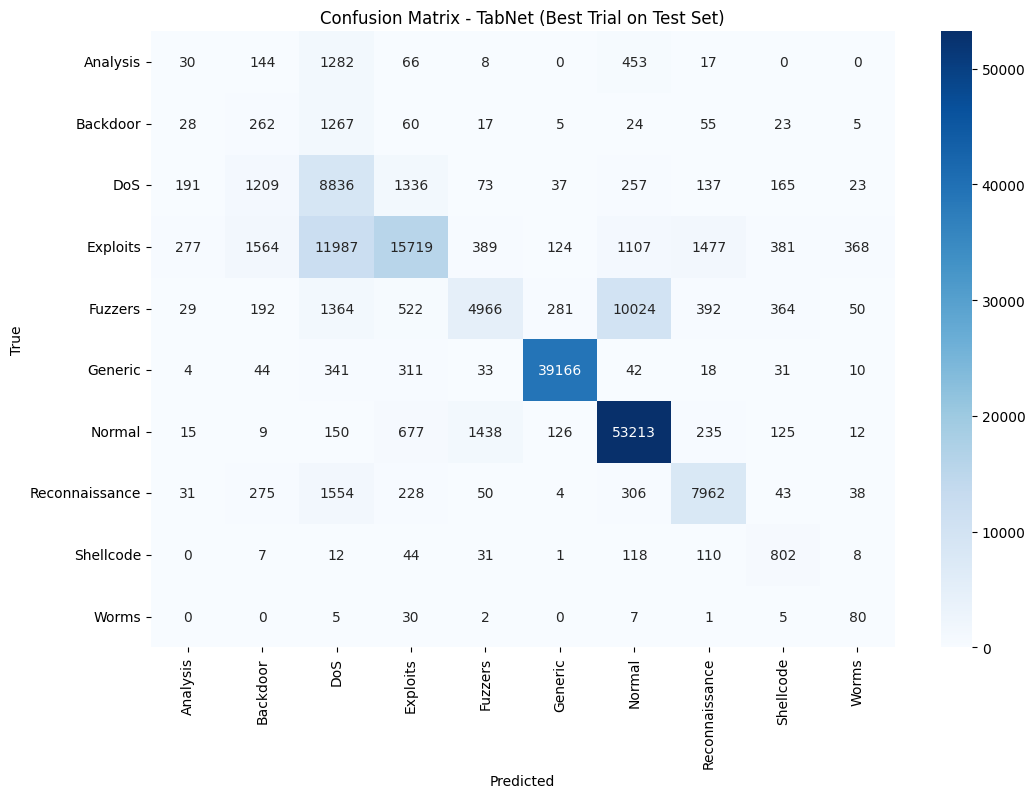

Successfully saved model at artifacts/tabnet_best_model.zip


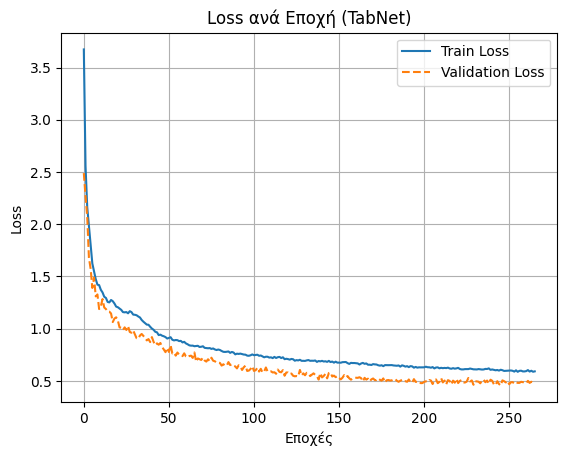

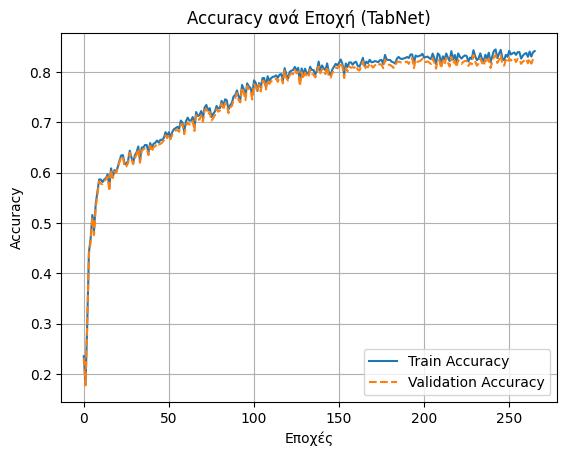


Classification Report στο Test Set:
                precision    recall  f1-score   support

      Analysis     0.0496    0.0150    0.0230      2000
      Backdoor     0.0707    0.1501    0.0961      1746
           DoS     0.3297    0.7205    0.4524     12264
      Exploits     0.8276    0.4707    0.6001     33393
       Fuzzers     0.7087    0.2731    0.3943     18184
       Generic     0.9855    0.9791    0.9823     40000
        Normal     0.8118    0.9502    0.8756     56000
Reconnaissance     0.7653    0.7589    0.7621     10491
     Shellcode     0.4136    0.7079    0.5221      1133
         Worms     0.1347    0.6154    0.2210       130

      accuracy                         0.7473    175341
     macro avg     0.5097    0.5641    0.4929    175341
  weighted avg     0.7881    0.7473    0.7409    175341


Macro F1 Score:      0.4929
Weighted F1 Score:   0.7409
Micro F1 Score:      0.7473
Macro Precision:     0.5097
Macro Recall:        0.5641


In [ ]:
# --------------------------------------------------------
# Evaluation on Test Set
# --------------------------------------------------------
print(f"\nΚαλύτερη Validation Accuracy: {best_acc:.4f}")
print("Καλύτερες υπερπαραμέτρους:", best_params)

y_pred_test = best_model.predict(X_test_tabnet.values)


# --------------------------------------------------------
# Confusion Matrix
# --------------------------------------------------------
cm = confusion_matrix(y_test_encoded, y_pred_test)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - TabNet (Best Trial on Test Set)")
plt.show()

# --------------------------------------------------------
# Αποθήκευση καλύτερου μοντέλου
# --------------------------------------------------------
export_path = "artifacts"
os.makedirs(export_path, exist_ok=True)
best_model.save_model(os.path.join(export_path, "tabnet_best_model"))

# --------------------------------------------------------
# Διαγράμματα εκπαίδευσης (Loss/Accuracy)
# --------------------------------------------------------
plt.figure()
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_logloss'], label='Validation Loss', linestyle='--')
plt.title("Loss ανά Εποχή (TabNet)")
plt.xlabel("Εποχές")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title("Accuracy ανά Εποχή (TabNet)")
plt.xlabel("Εποχές")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()




# --------------------------------------------------------
# Classification Report
# --------------------------------------------------------
print("\nClassification Report στο Test Set:")
print(classification_report(y_test_encoded, y_pred_test, target_names=label_encoder.classes_,digits=4))

print(f"\nMacro F1 Score:      {f1_score(y_test_encoded, y_pred_test, average='macro'):.4f}")
print(f"Weighted F1 Score:   {f1_score(y_test_encoded, y_pred_test, average='weighted'):.4f}")
print(f"Micro F1 Score:      {f1_score(y_test_encoded, y_pred_test, average='micro'):.4f}")
print(f"Macro Precision:     {precision_score(y_test_encoded, y_pred_test, average='macro'):.4f}")
print(f"Macro Recall:        {recall_score(y_test_encoded, y_pred_test, average='macro'):.4f}")

## 6.Κατέβασμα αρχείων μοντέλου για χρήση απο API

In [ ]:
# Δημιουργία zip από τον φάκελο /content/artifacts
shutil.make_archive("artifacts", 'zip', "/content/artifacts")

# katέβασμα τοπικά
files.download("artifacts.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>